# Sentiment detection using Markov Models.
- First-order markov
- Second-order markov

In [1]:
import re
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk import word_tokenize
import matplotlib.pyplot as plt
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tag import pos_tag
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

### Text clean up

In [2]:
def remove_unwanted(x):
    new_x = re.sub(r'<[^>]*>', '', x) #remove html tags
    new_x = re.sub(r"http\S+", "", new_x) #remove http links
    new_x = re.sub(r"@\S+", "", new_x) #remove twitter user tags
    new_x = re.sub(r"#\S+", "", new_x) #remove #tags
    new_x = new_x.translate(str.maketrans('', '', string.punctuation))
    new_x = " ".join([txt for txt in new_x.lower().split() if len(txt.strip()) > 0])
    x_tags = pos_tag(new_x.split()) # get part-of-speech tags for each token in a text.
    new_x = " ".join([lemmatizer.lemmatize(m, pos = detect_pos_tag(tag)) for m, tag in x_tags]) # lemmatize based on the POS tags.
    
    return new_x

def detect_pos_tag(tag):
    if tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

data = pd.read_csv("../corona tweets/Corona_NLP_train.csv", encoding='latin-1')
data.drop(["UserName","ScreenName", "Location", "TweetAt"], axis=1, inplace=True)
data["tweets"] = data["OriginalTweet"].apply(remove_unwanted)
data.head()

,OriginalTweet,Sentiment,tweets
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,and and
1,advice Talk to your neighbours family to excha...,Positive,advice talk to your neighbour family to exchan...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworth to give elderl...
3,My food stock is not the only one which is emp...,Positive,my food stock be not the only one which be emp...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready to go at supermarket during the outbr...


#### Remove tweets of length less than 1. Let's consider **extremely positive** as positive and **extremely negative** as negative

In [3]:
data = data[data["tweets"].str.len() > 1]

codes = {
    "Positive": 0,
    "Neutral": 2,
    "Negative": 1
}

def label_changer(y):
    if y == "Extremely Positive":
        return codes["Positive"]
    elif y == "Extremely Negative":
        return codes["Negative"]
    else:
        return codes[y]

data["labels"] = data["Sentiment"].apply(label_changer)

data = data[data["labels"] < 2]
data.head()

,OriginalTweet,Sentiment,tweets,labels
1,advice Talk to your neighbours family to excha...,Positive,advice talk to your neighbour family to exchan...,0
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworth to give elderl...,0
3,My food stock is not the only one which is emp...,Positive,my food stock be not the only one which be emp...,0
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready to go at supermarket during the outbr...,1
5,As news of the regionÂs first confirmed COVID...,Positive,a news of the regionâs first confirm covid19 ...,0


#### For this model, consider only **positive** and **negative** reviews.

0    18044
1    15397
Name: labels, dtype: int64


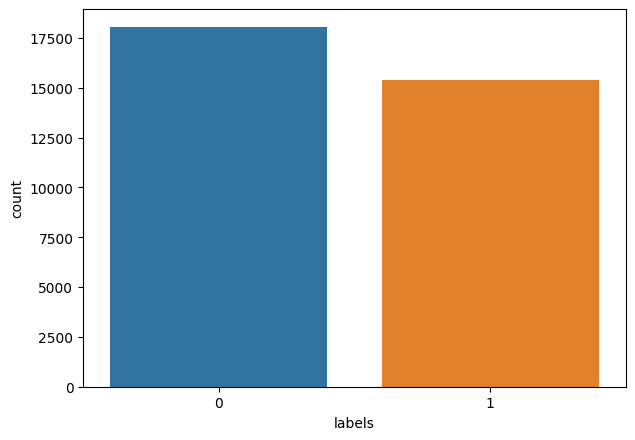

In [4]:
print(data["labels"].value_counts())
plt.figure(figsize=(7, 5), dpi = 100)
sns.countplot(data['labels']);

**Data is not perfectly balanced.**

In [5]:
X = data["tweets"].tolist()
y = data["labels"].tolist()

xtrain, xtest, ytrain, ytest = train_test_split(X, y,
                                                stratify = y,
                                                test_size = 0.05, 
                                                random_state = 17)

#### Create a mapping between word and id, ***word --> id***

In [6]:
idx = 1
word2idx = {"<unk>": 0}

for text in xtrain:
    text = text.replace("\n", " ")
    tokens = text.split()
    for token in tokens:
        if token not in word2idx:
            word2idx[token] = idx
            idx += 1

len(word2idx)

32173

##### Vocabulary

In [7]:
V = len(word2idx)
V

32173

#### Create a reverse mapping ***id --> word***

In [8]:
idx2word = {j:i for i, j in word2idx.items()}

#### Convert all the text tokens into ids using word2idx created above.

In [9]:
xtrain_int = []
xtest_int = []

for text in xtrain:
    text = text.replace("\n", " ")
    tokens = text.split()
    line_int = [word2idx[token] for token in tokens]
    xtrain_int.append(line_int)

for text in xtest:
    text = text.replace("\n", " ")
    tokens = text.split()
    line_int = [word2idx.get(token, 0) for token in tokens]
    xtest_int.append(line_int)

In [10]:
print("Text converted to id --->\n\n", xtrain_int[1], "\n\nText --->\n\n", xtrain[1])

Text converted to id --->

 [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 22, 25, 33, 34, 35, 36, 37, 38, 39, 32, 40, 22, 41, 6, 42, 43, 5, 35, 44, 45, 5, 46, 24, 23, 47, 22, 48, 49] 

Text --->

 we know you re worried about bill during covid 19 and we re work with our insurer on relief option and discount we ll be reach out to our client soon to let you know how we can help


## First-order Markov model
#### We are creating seperate probabilistic model for each class.
- initial_pos and initial_neg are the initial state distributions for positive and negative, which relates to the first word in a sentence.
- first_order_pos (positive) and first_order_neg (negative) are the transition state matrix for each class, which contains log probabilities of transition between words.

In [11]:
initial_pos = {}
first_order_pos = {}

initial_neg = {}
first_order_neg = {}

#### Compute counts/frequency for initial state and transition state matrix.

In [12]:
def compute_counts(txt_to_int, initials, transitions):
    for tokens in txt_to_int:
        last_idx = None
        for idx in tokens:
            if last_idx is None:
                initials[idx] = initials.get(idx, 1) + 1
            else:
                if last_idx not in transitions:
                    transitions[last_idx] = {idx : 2}
                else:
                    transitions[last_idx][idx] = transitions[last_idx].get(idx, 1) + 1
            
            last_idx = idx
    
    return initials, transitions

initial_pos, first_order_pos = compute_counts([x for x, y in zip(xtrain_int, ytrain) if y == 0], initial_pos, first_order_pos)
initial_neg, first_order_neg = compute_counts([x for x, y in zip(xtrain_int, ytrain) if y == 1], initial_neg, first_order_neg)

#### Compute word frequency for the entire vocabulary.

In [13]:
def frequency(xx):
    word_freq = {}
    for text in xx:
        text = text.replace("\n", " ")
        tokens = text.split()
        for token in tokens:
            if token not in word_freq:
                word_freq[token] = 1
            else:
                word_freq[token] += 1
    
    return word_freq

word_freq_pos = frequency([x for x, y in zip(xtrain, ytrain) if y == 0])
word_freq_neg = frequency([x for x, y in zip(xtrain, ytrain) if y == 1])

word_frequency = dict(Counter(word_freq_pos) + Counter(word_freq_neg))

#### Words appearing in positive reviews.

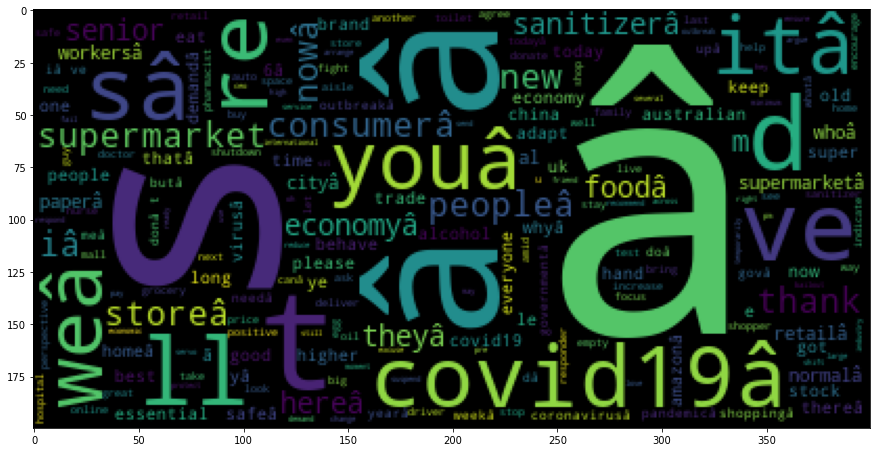

In [14]:
# words appearing in positive reviews.
plt.figure(figsize=(15, 12))
positive_cloud = WordCloud().generate(' '.join([wc for wc in word_freq_pos.keys()]))
plt.imshow(positive_cloud)

#### Words appearing in negative reviews.

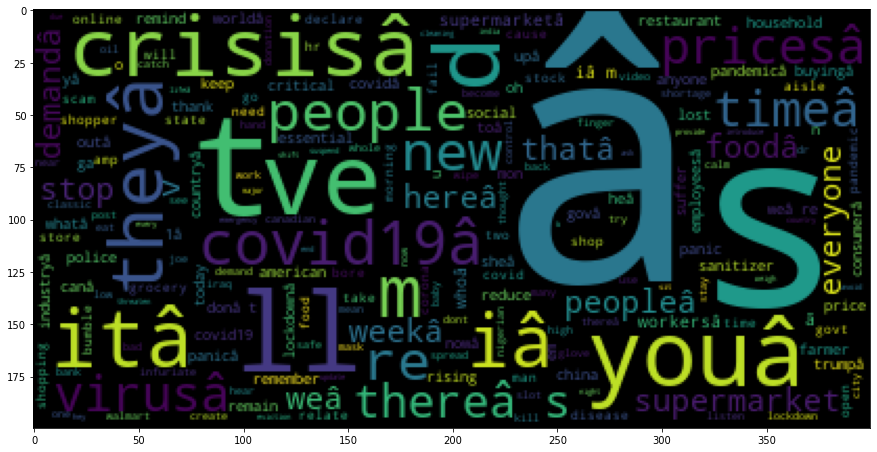

In [15]:
# words appearing in positive reviews.
plt.figure(figsize=(15, 12))
negative_cloud = WordCloud().generate(' '.join([wc for wc in word_freq_neg.keys()]))
plt.imshow(negative_cloud)

#### Function that calculates log probabilities.

In [16]:
def transition_logs(d, k):
    new_d = {}
    word = idx2word[k]
    for nk, v in d.items():
        new_d[nk] = np.log((v + 1) / word_frequency[word])
    
    return new_d

In [17]:
ipos_sum = sum(initial_pos.values())
ineg_sum = sum(initial_neg.values())

for key, val in initial_pos.items():
    initial_pos[key] = np.log(val / ipos_sum)

for key, val in initial_neg.items():
    initial_neg[key] = np.log(val / ineg_sum)

In [18]:
for key, val in first_order_pos.items():
    first_order_pos[key] = transition_logs(val, key)

for key, val in first_order_neg.items():
    first_order_neg[key] = transition_logs(val, key)

#### Calculate prior log probabilities for each class (positive and negative).

In [19]:
count0 = sum(y==0 for y in ytrain)
count1 = sum(y==1 for y in ytrain)

total = len(ytrain)

p0 = count0 / total
p1 = count1 / total

logp0 = np.log(p0)
logp1 = np.log(p1)

In [20]:
count0, count1

(17141, 14627)

In [21]:
logp0, logp1

(-0.6169862393040303, -0.7755903579239991)

#### Define a class which computes log likelihood & also design predict function.

In [22]:
class Classifier:
    def __init__(self, logAs, logpis, logpriors, word_freq):
        self.logAs = logAs
        self.logpis = logpis
        self.logpriors = logpriors
        self.word_freq = word_freq
        self.K = len(logpriors)
    
    def compute_log_likelihood(self, input_, class_):
        logA = self.logAs[class_]
        logpi = self.logpis[class_]
        
        last_idx = None
        logprob = 0

        for idx in input_:
            if last_idx is None:
                if idx in logpi:
                    logprob += logpi[idx]
            else:
                if last_idx in logA:
                    if idx in logA[last_idx]:
                        logprob += logA[last_idx][idx]
                    else:
                        word = idx2word[last_idx]
                        freq = self.word_freq[word]
                        logprob += np.log(1 / freq)
        
            last_idx = idx
        
        return logprob

    def predict(self, inputs):
        predictions = np.zeros(len(inputs))
        for e, input_ in enumerate(inputs):
            posteriors = [self.compute_log_likelihood(input_, c) + self.logpriors[c] for c in range(self.K)]
            prediction = np.argmax(posteriors)
            predictions[e] = prediction
        
        return predictions

In [23]:
clf = Classifier([first_order_pos, first_order_neg],
                 [initial_pos, initial_neg],
                 [logp0, logp1],
                  word_frequency)
ptrain = clf.predict(xtrain_int)
ptest = clf.predict(xtest_int)

#### Classification report for training.

In [24]:
print(classification_report(ytrain, ptrain))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96     17141
           1       0.97      0.93      0.95     14627

    accuracy                           0.95     31768
   macro avg       0.95      0.95      0.95     31768
weighted avg       0.95      0.95      0.95     31768



In [25]:
confusion_matrix(ytrain, ptrain)

array([[16659,   482],
       [ 1065, 13562]], dtype=int64)

#### Classification report for validation.

In [26]:
print(classification_report(ytest, ptest))

              precision    recall  f1-score   support

           0       0.69      0.89      0.78       903
           1       0.81      0.52      0.63       770

    accuracy                           0.72      1673
   macro avg       0.75      0.71      0.71      1673
weighted avg       0.74      0.72      0.71      1673



In [27]:
confusion_matrix(ytest, ptest)

array([[808,  95],
       [368, 402]], dtype=int64)

In [28]:
print("Training metrics --->\n")

print(f"F1-score - {f1_score(ytrain, ptrain):.3f}")
print(f"Precision - {precision_score(ytrain, ptrain):.3f}")
print(f"Recall - {recall_score(ytrain, ptrain):.3f}")
print(f"Auc - {roc_auc_score(ytrain, ptrain):.3f}")

Training metrics --->

F1-score - 0.946
Precision - 0.966
Recall - 0.927
Auc - 0.950


In [29]:
print("Validation metrics --->\n")
print(f"F1-score - {f1_score(ytest, ptest):.3f}")
print(f"Precision - {precision_score(ytest, ptest):.3f}")
print(f"Recall - {recall_score(ytest, ptest):.3f}")
print(f"Auc - {roc_auc_score(ytest, ptest):.3f}")

Validation metrics --->

F1-score - 0.635
Precision - 0.809
Recall - 0.522
Auc - 0.708


## Second-order Markov model
- Here we have extra components second_order_pos and second_order_neg, they keep track upto 2 previous words for a current word.

In [30]:
initial_pos = {}
first_order_pos = {}
second_order_pos = {}

initial_neg = {}
first_order_neg = {}
second_order_neg = {}

In [31]:
def compute_counts(txt_to_int, initials, transition_f, transition_s):
    for tokens in txt_to_int:
        for e, idx in enumerate(tokens):
            if e == 0:
                initials[idx] = initials.get(idx, 1) + 1
            elif e == 1:
                last_idx = tokens[e - 1]
                if last_idx not in transition_f:
                    transition_f[last_idx] = {idx : 2}
                else:
                    transition_f[last_idx][idx] = transition_f[last_idx].get(idx, 1) + 1
            
            elif e > 1:
                prev_token2 = tokens[e - 2]
                prev_token1 = tokens[e - 1]
                last_idx = (prev_token2, prev_token1)
                if last_idx not in transition_s:
                    transition_s[last_idx] = {idx: 2}
                else:
                    transition_s[last_idx][idx] = transition_s[last_idx].get(idx, 1) + 1
    
    return initials, transition_f, transition_s

initial_pos, first_order_pos, second_order_pos = compute_counts([x for x, y in zip(xtrain_int, ytrain) if y == 0],
                                              initial_pos,
                                              first_order_pos,
                                              second_order_pos)

initial_neg, first_order_neg, second_order_neg = compute_counts([x for x, y in zip(xtrain_int, ytrain) if y == 1],
                                               initial_neg, 
                                               first_order_neg,
                                               second_order_neg)

In [32]:
def combo_frequency(d):
    freq = {}
    for key, val in d.items():
        freq[key] = sum(val.values())
    
    return freq

combo_freq_pos = combo_frequency(second_order_pos)
combo_freq_neg = combo_frequency(second_order_neg)

combo_freq = dict(Counter(combo_freq_pos) + Counter(combo_freq_neg))

In [33]:
def second_transition_logs(d, k):
    new_d = {}
    for nk, v in d.items():
        new_d[nk] = np.log((v + 1) / combo_freq[k])
    
    return new_d

In [34]:
ipos_sum = sum(initial_pos.values())
ineg_sum = sum(initial_neg.values())

for key, val in initial_pos.items():
    initial_pos[key] = np.log(val / ipos_sum)

for key, val in initial_neg.items():
    initial_neg[key] = np.log(val / ineg_sum)

for key, val in first_order_pos.items():
    first_order_pos[key] = transition_logs(val, key)

for key, val in first_order_neg.items():
    first_order_neg[key] = transition_logs(val, key)

for key, val in second_order_pos.items():
    second_order_pos[key] = second_transition_logs(val, key)

for key, val in second_order_neg.items():
    second_order_neg[key] = second_transition_logs(val, key)

In [35]:
count0 = sum(y==0 for y in ytrain)
count1 = sum(y==1 for y in ytrain)

total = len(ytrain)

p0 = count0 / total
p1 = count1 / total

logp0 = np.log(p0)
logp1 = np.log(p1)

In [36]:
logp0, logp1

(-0.6169862393040303, -0.7755903579239991)

In [37]:
class Classifier:
    def __init__(self, logSs, logAs, logpis, logpriors, word_f, combo_f):
        self.logSs = logSs
        self.logAs = logAs
        self.logpis = logpis
        self.logpriors = logpriors
        self.word_freq = word_f
        self.combo_freq = combo_f
        self.K = len(logpriors)
    
    def compute_log_likelihood(self, input_, class_):
        logS = self.logSs[class_]
        logA = self.logAs[class_]
        logpi = self.logpis[class_]
        
        logprob = 0

        for e, idx in enumerate(input_):
            if e == 0:
                if idx in logpi:
                    logprob += logpi[idx]
            elif e == 1:
                last_idx = input_[e - 1]
                if last_idx in logA:
                    if idx in logA[last_idx]:
                        logprob += logA[last_idx][idx]
                    else:
                        word = idx2word[last_idx]
                        freq = self.word_freq[word]
                        logprob += np.log(1/freq)
        
            elif e > 1:
                prev_token2 = input_[e - 2]
                prev_token1 = input_[e - 1]
                last_idx = (prev_token2, prev_token1)
                if last_idx in logS:
                    if idx in logS[last_idx]:
                        logprob += logS[last_idx][idx]
                    else:
                        freq = self.combo_freq[last_idx]
                        logprob += np.log(1 / freq)
        
        return logprob

    def predict(self, inputs):
        predictions = np.zeros(len(inputs))
        for e, input_ in enumerate(inputs):
            posteriors = [self.compute_log_likelihood(input_, c) + self.logpriors[c] for c in range(self.K)]
            prediction = np.argmax(posteriors)
            predictions[e] = prediction
        
        return predictions

In [38]:
clf = Classifier([second_order_pos, second_order_neg],
                 [first_order_pos, first_order_neg],
                 [initial_pos, initial_neg],
                 [logp0, logp1],
                 word_frequency,
                 combo_freq)
                 
ptrain = clf.predict(xtrain_int)
ptest = clf.predict(xtest_int)

#### Classification report for training.

In [39]:
print(classification_report(ytrain, ptrain))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     17141
           1       0.95      0.95      0.95     14627

    accuracy                           0.96     31768
   macro avg       0.96      0.96      0.96     31768
weighted avg       0.96      0.96      0.96     31768



In [40]:
confusion_matrix(ytrain, ptrain)

array([[16431,   710],
       [  704, 13923]], dtype=int64)

#### Classification report for validation.

In [41]:
print(classification_report(ytest, ptest))

              precision    recall  f1-score   support

           0       0.64      0.70      0.67       903
           1       0.60      0.53      0.56       770

    accuracy                           0.62      1673
   macro avg       0.62      0.61      0.61      1673
weighted avg       0.62      0.62      0.62      1673



In [42]:
confusion_matrix(ytest, ptest)

array([[632, 271],
       [362, 408]], dtype=int64)

In [43]:
print("Training metrics --->\n")

print(f"F1-score - {f1_score(ytrain, ptrain):.3f}")
print(f"Precision - {precision_score(ytrain, ptrain):.3f}")
print(f"Recall - {recall_score(ytrain, ptrain):.3f}")
print(f"Auc - {roc_auc_score(ytrain, ptrain):.3f}")

Training metrics --->

F1-score - 0.952
Precision - 0.951
Recall - 0.952
Auc - 0.955


In [44]:
print("Validation metrics --->\n")
print(f"F1-score - {f1_score(ytest, ptest):.3f}")
print(f"Precision - {precision_score(ytest, ptest):.3f}")
print(f"Recall - {recall_score(ytest, ptest):.3f}")
print(f"Auc - {roc_auc_score(ytest, ptest):.3f}")

Validation metrics --->

F1-score - 0.563
Precision - 0.601
Recall - 0.530
Auc - 0.615
